In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im
%matplotlib notebook
from shift import *
from convolve import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Bilateral filter

$\textbf{1.}$

In [4]:
x = plt.imread('castle.png')

In [5]:
sig = 10 / 255
y = x + sig * np.random.randn(*x.shape)

$\textbf{2.}$

In [6]:
def phi(alpha,C,h,sig):
    a = np.maximum(alpha-2*h*(sig**2),0)
    b = 2*np.sqrt(2)*h*(sig**2)/np.sqrt(C)
    inner = -a/b
    return np.exp(inner)

In [7]:
def bilateral_naive(y, sig, s1=2, s2=2, h=1):
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim - 2)))
    for i in range(s1, n1-s1):
        for j in range(s2, n2-s2):
            tmp1 = 0
            tmp2 = 0
            for k in range(-s1, s1 + 1):
                for l in range(-s2, s2 + 1):
                    dist2 = ((y[i + k, j + l] - y[i, j])**2).mean()
                    tmp1 += phi(dist2,c,h,sig) * y[i + k][j + l]   
                    tmp2 += phi(dist2,c,h,sig)
            x[i][j] = tmp1
            Z[i][j] = tmp2 
    Z[Z == 0] = 1
    x = x / Z
    return x

$\textbf{4.}$

In [8]:
def bilateral(y, sig, s1=10, s2=10, h=1, boundary= 'mirror'):
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim - 2)))
    for k in range(-s1, s1 + 1):
        for l in range(-s2, s2 + 1):
            tmp = phi(((shift(y,k,l,boundary) - y)**2).mean(axis = 2),c,h,sig)
            tmp_new = np.moveaxis((tmp.reshape(1,n1,n2)),[0,1,2],[2,0,1])
            x += tmp_new*shift(y,k,l,boundary)
            Z += tmp_new
            
            #x1 = np.multiply(tmp,shift(y,k,l,boundary)[:,:,0])
            #x2 = np.multiply(tmp,shift(y,k,l,boundary)[:,:,1])
            #x3 = np.multiply(tmp,shift(y,k,l,boundary)[:,:,2])
            #x += np.stack([x1,x2,x3],axis = 2)
            #Z += np.moveaxis((tmp.reshape(1,481,321)),[0,1,2],[2,0,1])
    Z[Z == 0] = 1
    x = x / Z
    return x

$\textbf{3.}$

<IPython.core.display.Javascript object>


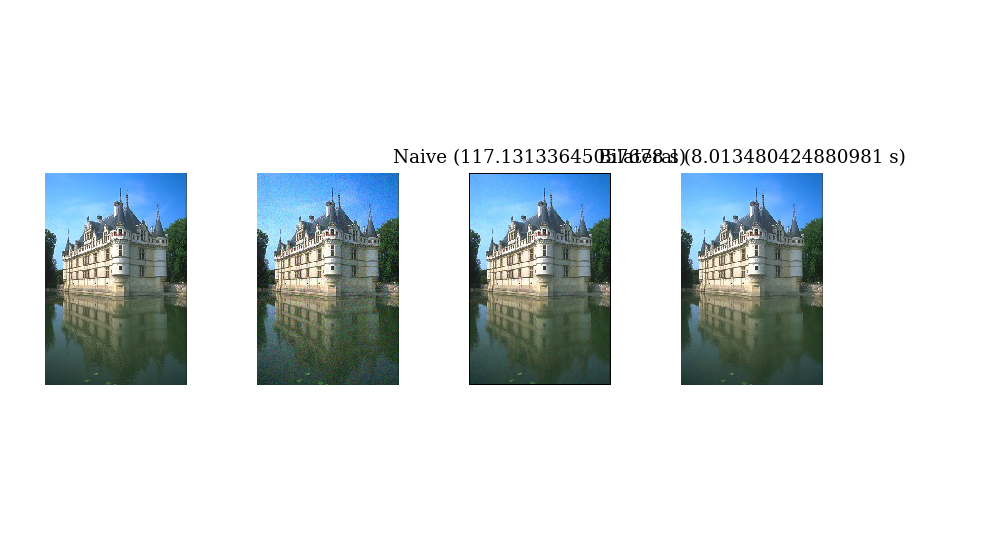

In [10]:
fig, axes = plt.subplots(ncols=4, figsize=(9,3))
im.show(x, ax=axes[0])
im.show(y, ax=axes[1])
start_time =time.time()
y_naive = bilateral_naive(y,sig,2,2,1)
elapse_time = time.time() -start_time
axes[2].set_title("Naive (" + str(elapse_time)+ " s)")
im.show(y_naive, ax=axes[2])
start_time = time.time()
y_bil = bilateral(y,sig,7,7,1)
elapse_time = time.time() - start_time
axes[3].set_title("Bilateral (" + str(elapse_time)+ " s)")
im.show(y_bil, ax=axes[3])

$\textbf{5.}$

In [11]:
start_time =time.time()
y_bil = bilateral(y,sig,2,2,1)
elapse_time = time.time() - start_time
print(str(elapse_time)+" s")

0.7197797298431396 s


$\textbf{According to the above results, the computational time of naive_bilateral is 97.14s.}$

$\textbf{On the other hands, the computational time of bilateral function is 0.6853s}$

$\textbf{6.}$

<IPython.core.display.Javascript object>


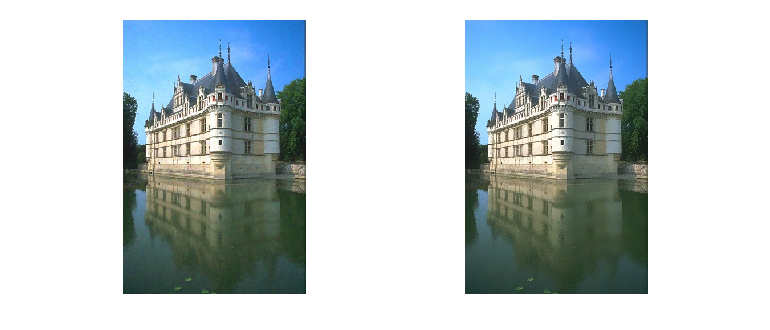

In [12]:
y_bil2 = bilateral(y,sig,2,2,1)
y_bil7 = bilateral(y,sig,7,7,1)
fig, axes = plt.subplots(ncols=2, figsize=(7,3))
im.show(y_bil2, ax=axes[0])
im.show(y_bil7, ax=axes[1])

$\textbf{The larger the search window is the smoother the result will become.}$

## 2. NL-means filter

$\textbf{7.}$

In [13]:
def phi_nl(alpha,C,h,sig,P):
    a = np.maximum(alpha-2*h*(sig**2),0)
    b = 2*np.sqrt(2)*h*(sig**2)/np.sqrt(C*P)
    inner = -a/b
    return np.exp(inner)

In [14]:
def nlmeans_naive(y, sig, s1=2, s2=2, p1=1, p2=1, h=1):
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim-2)))
    
    P = (2*p1+1)*(2*p2+1)
    for i in range(s1, n1-s1-p1):
        for j in range(s2, n2-s2-p2):
            for k in range(-s1, s1+1):
                for l in range(-s2, s2+1):
                    dist2 = 0
                    for u in range(-p1, p1+1):
                        for v in range(-p2, p2+1):
                            dist2 += ((y[i+k+u, j+l+v]-y[i+u, j+v])**2)
                    kernel = phi_nl(dist2.mean()/P, c,h,sig, P)
                    Z[i,j] += kernel
                    x[i,j] += kernel*y[i+k,j+l]
                    
    Z[Z==0] = 1
    x = x/ Z
    return x

$\textbf{8.}$

In [15]:
sig = 20 / 255
x1 = plt.imread('leopard.png')
y1 = x1 + sig * np.random.randn(*x1.shape)

In [16]:
y1_naive = nlmeans_naive(y1,sig,2,2,1,1,1)

<IPython.core.display.Javascript object>


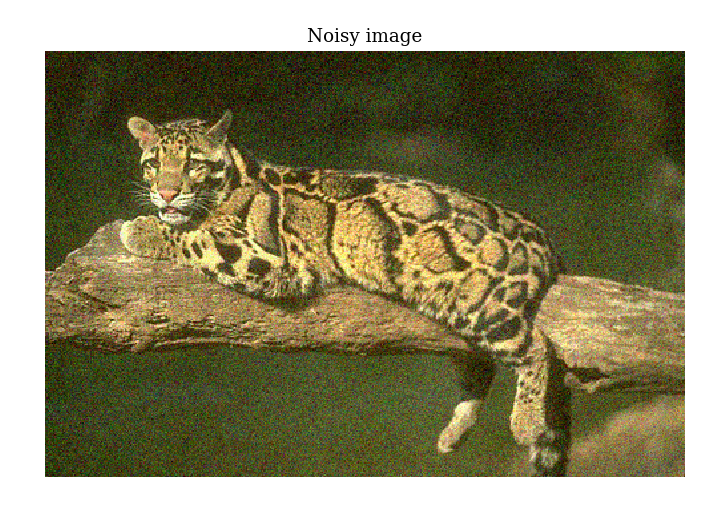

<IPython.core.display.Javascript object>


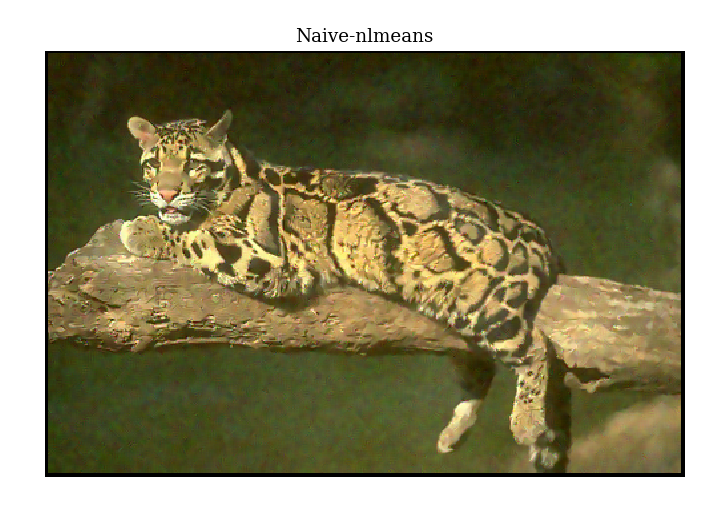

In [17]:
plt.figure()
plt.title("Noisy image")
im.show(y1)
plt.figure()
plt.title("Naive-nlmeans")
im.show(y1_naive)

$\textbf{9.}$

In [ ]:
def nlmeans(y, sig, s1=7, s2=7, p1=None, p2=None, h=1, boundary='mirror'):
    p1 = (1 if y.ndim == 3 else 2) if p1 is None else p1
    p2 = (1 if y.ndim == 3 else 2) if p2 is None else p2
    # Making box kernel
    P = (2*p1+1)*(2*p2+1) 
    i = np.arange(-p1,p1+1) #-1 ~ 1
    j = np.arange(-p2,p2+1) #-1 ~ 1
    ii, jj = np.meshgrid(i, j, sparse=True,indexing='ij')
    nu = np.exp(0*(ii+jj))
    nu[nu < 1e-3] = 0
    nu /= nu.sum()
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim - 2)))
    #only need two loop --> there are also two loops in convolve function
    for k in range(-s1, s1 + 1):
        for l in range(-s2, s2 + 1):
            #using convolve function
            tmp = phi_nl((convolve((shift(y,k,l,boundary) - y)**2,nu,boundary)).mean(axis = 2),c,h,sig,P)
            x += tmp[:,:,None]*shift(y,k,l,boundary)
            Z += tmp[:,:,None]
    x = x / Z
    return x

$\textbf{The patch size is 3 x 3 if the image is RGB, otherwise, the patch size will be 5 x 5}$

$\textbf{10.}$

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
start_time =time.time()
y1_naive = nlmeans_naive(y1,sig,2,2,1,1,1)
elapse_time = time.time() - start_time
axes[0].set_title("Naive (" + str(elapse_time)+ " s)")
im.show(y1_naive, ax=axes[0])
start_time =time.time()
y1_nl = nlmeans(y1,sig,2,2,1,1,1)
elapse_time = time.time() - start_time
axes[1].set_title("Nlmeans (" + str(elapse_time)+ " s)")
im.show(y1_nl, ax=axes[1])

$\textbf{My new function is only 61 times faster}$

$\textbf{11.}$

$\textbf{1. The true calculation times for the naive NLM is (2p1+1) x (2p2+1) x (2s1+1) x (2s2+1) x n1 x n2}$

$\textbf{--> which means the time complexity is O(n|N||P|), where n is the image size, N is search window size, P is patch size}$

$\textbf{2. The complexity for the revised form NLMs is also O(n|N||P|)}$

$\textbf{12.}$

In [ ]:
def psnr(x,x0):
    n1, n2 = x.shape[:2]
    c = x.shape[2] if x.ndim == 3 else 1
    return 10*np.log10(n1*n2*c/(np.linalg.norm(x-x0)**2))

$\textbf{13.}$

In [ ]:
fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(10,3))
axes[0][0].set_title("Original")
im.show(x1, ax=axes[0][0])
axes[0][1].set_title("Noisy")
im.show(y1, ax=axes[0][1])
start_time = time.time()
y_bil = bilateral(y1,sig,7,7,1)
elapse_time = time.time() - start_time
err = psnr(y_bil,x1)
axes[1][0].set_title("Bilateral (" +str(err)+" dB ), " + str(elapse_time) + " s")
im.show(y_bil, ax=axes[1][0])
start_time = time.time()
y_nl = nlmeans(y1,sig,7,7,1,1)
elapse_time = time.time() - start_time
err = psnr(y_nl,x1)
axes[1][1].set_title("NLM (" +str(err)+" dB ), " + str(elapse_time) + " s")
im.show(y_nl, ax=axes[1][1])

$\textbf{14.}$

In [ ]:
noise = [10 / 255,20 / 255,100 / 255,255/255]
hh = [0.5,1,2,4,8]
row = 0
nl_snr = np.zeros((len(noise),len(hh)))
bil_snr = np.zeros((len(noise),len(hh)))
for sig in noise:
    y1 = x1 + sig * np.random.randn(*x1.shape)
    col = 0
    for h in hh:
        start_time = time.time()
        y_nl = nlmeans(y1,sig,7,7,1,1,h)
        elapse_time = time.time() - start_time
        nl_snr[row][col] = psnr(y_nl,x1)
        print("NLM sigma = " + str(sig)+", filter param = " + str(h)+": PSNR = " + str(nl_snr[row][col] ) + " dB " + str(elapse_time) +" s")
        start_time = time.time()
        y_bil = bilateral(y1,sig,7,7,h)
        elapse_time = time.time() - start_time
        bil_snr[row][col] = psnr(y_bil,x1)
        print("BIL sigma = " + str(sig)+", filter param = " + str(h)+": PSNR = " + str(bil_snr[row][col]) + " dB " + str(elapse_time) +" s")
        col += 1
    row += 1

In [ ]:
nn = 3 # 0~3
plt.figure()
plt.title('h distribution, when noise = '+ str(noise[nn]))
plt.plot(hh,nl_snr[nn,:],'C1')
plt.plot(hh,bil_snr[nn,:],'b')

hp = 4 # 0~4
plt.figure()
plt.title('noise distribution, when h = '+str(hh[hp]))
plt.plot(noise,nl_snr[:,hp],'C1')
plt.plot(noise,bil_snr[:,hp],'b')

### What do you observe:


$\textbf{The plot shows that the higher the noise level is, it is more difficult to recover the original image.}$

$\textbf {Besides, in different noise level, there will have a certain value of filter parameter that gets the optimal PSNR solution}$